#### GISC 420 T1 2021
# Exploring `python` in *QGIS*
In this notebook we look at some of the ways that `python` can be used to automate operations in *QGIS*. Similar capabilities are available in the ESRI Arc platform.

Note that this is a huge topic and this session is only intended to give you the most basic of introductions. Doing anything much beyond very simple manipulations of layers in an automated fashion via the programming APIs for these platforms is challenging. Processing workflows using the tools in the respective toolboxes can be more easily automated, and this can even be done without any programming at all! 

For these reasons, this material focuses on 
+ Using [the python console in QGIS](#The-python-console-in-QGIS), and
+ Automating workflows with [Model Designer in QGIS](#Model-designer-in-QGIS)

Unfortunately [building plugins in QGIS](#Building-plugins-in-QGIS) is a more advanced topic, which we don't have time for, although we will also briefly look at a couple of examples.

### Before we start
To explore the possibilities that all this opens up we will open up QGIS and play around with some code in the console. To get set up for this we will first add a Web Feature Service (WFS) layer to a project. We will add a layer from GNS. The information about the available services is available on [this page](https://maps.gns.cri.nz/).

To add their WFS catalogue do **Layer - Add Layer - Add WFS Layer...**, then select **New** and provide this URL:

    https://maps.gns.cri.nz/geology/wfs

along with a name ('GNS WFS' will do). Then click **OK** then **Close**.

<img src="add-a-WFS.png" width="300">

In the **Browser** part of the user interface you should now see under the **WFS / OGC API - Features** an entry for the service you just added. Open the list of available layers with the (tiny) right-arrow button and right-click the layer called *NZL_GNS_250K_faults* (it's near the bottom of the list) and select **Add Layer to Project**. The layer should appear in the project table of contents.

This can be styled from the **Properties** dialogue just like any other layer.

## The python console in QGIS
The first thing to realise is that python is _right there_ in QGIS. Select **Plugins - Python Console** from the main menubar. To see it. It will open up somewhere in the window (you may find it easier to work with if you detach it from the main window. 

<img src="python-console.png" width="600">

You can also change the font size by right-clicking in the upper part of the dialog and selecting **Options** then changing fonts (or other options) in the **Code Editor section**.



### Hey, there's `python`, right there!
The lower part of this display with the `>>>` prompt is where you can type commands. Try an oldie-but-goodie 

    >>> print("Hello, World!")
    
just as you would in *IDLE*, or in a `python` shell. 

What's different here is that because we are running inside *QGIS* core `pyqgis` modules are loaded. Try this

    >>> layer = iface.activeLayer()
    >>> layer.sourceName()
    
You should get the response in the upper half of the console

    'NZL_GNS_250K_faults'
    
If not, check you set things up correctly as described in the previous section. `iface` refers to the interface, and the `activeLayer()` function returns an object representing the active layer, which in our project is the only layer loaded. Now try

    >>> layer

This time you should get

    <QgsVectorLayer: 'NZL_GNS_250K_faults' (WFS)>
    
which tells us that `layer` is an instance of the `QgsVectorLayer` class... and so it begins. Let's fire up the documentation and see what that means. Click this link: [https://qgis.org/pyqgis/master/core/QgsVectorLayer.html](https://qgis.org/pyqgis/master/core/QgsVectorLayer.html). 

You should find yourself in the documentation for the python API to *QGIS* which is called `pyqgis`. 

*QGIS* itself is written in C++ but it can be automated using the python API. And ugh how complicated is it?! Very complicated is how complicated it is.

We can see for example, that the `QgsVectorLayer` class can do a lot of things, but almost all of them involve digging ever deeper into the documentation until you run into something you recognise!

Anyway...

### Let's try a few things
How about we count the features in the layer:

    >>> layer.featureCount()
    
That was easy. How about we add together their lengths? Inspection of the layer tells us there is an attribute called `length`, so we could do this:

    >>> lengths = []
    >>> for fault in layer.getFeatures():
            lengths.append(fault.attribute("length")
    >>> print(sum(lengths))

You'll start to see the limations of the console here. You have to indent by hand (it doesn't do it automatically), and it's fiddly as all get out given how enthusiastic the console is to 'help' with information about class names and so forth. But if you get past all that it works. Another option is to open an editor window and prepare more complicated chunks of code there. The editor is accessed by right-clicking **Show Editor** in the upper part of the console.

Of course the above code isn't totally programmatic, since it didn't get a list of the field names and work from there. We could write code to also do that:

    >>> for fld in layer.fields():
            print(fld.name())
            
and you can perhaps imagine how more complicated code could be developed to automatically manage and manipulate the layers in a project in a variety of more or less complicated ways.

### One more trick, just for fun    
If you issue the following rather convoluted command:

    >>> iface.addVectorLayer("https://maps.gns.cri.nz/geology/wfs?&REQUEST=GetFeaturesTYPENAME=gns:NZL_GNS_1M_geological_units&SRSNAME=EPSG:4326", "Geological Units", "WFS")
    
You should see an new layer get 'automagically' added to the project table of contents.

## Model Designer in QGIS
The above all seems pretty great (sort of) but many tasks we might wish to automate already have tools (in the toolbox) that can accomplish them fairly readily, and all we need to do is chain them together correctly. That's exactly what the Model Designer in *QGIS* (or the Model Builder in *ArcGIS*) is for, so we'll look at that now, using a couple of examples to show some of the pros and cons. 

### A straightforward example
One of the 'mini-project' ideas suggests looking at building [Voronoi (proximity) polygons for shapes not limited to points](https://github.com/DOSull/GISC-420/tree/master/labs/mini-projects#multitype-voronoi). Here is a QGIS model that can do this for polygons:

<img src="voronoi/polygon-voronoi-model.png">

Let's see how this is assembled. To do that, we'll open a QGIS project with this [dataset of buildings](voronoi/buildings.gpkg?raw=true).

### A more complicated example
Wow! That was easy! 

Unfortunately, it's not always so straightforward. Another example is a model to generate travel time isochrones from a set of transit stops (bus stops say). This looks simpler than the previous case:

<img src="transit/isochrone-builder-model.png">

This time, rather than build it on the fly, we'll look at an [example model I have already built](transit/route-29.qgz?raw=true), and how things can get messy...

### Here's some `python` code that can make isochrones
I probably wouldn't do either of these tasks using Model Designer (or for that matter Model Builder in Arc). 
Instead I'd write `python` code or perhaps use *R*.

Below is how I would do it (or could do it) in `python`.

In [1]:
# first make some simple functions 
# to do the calculations - note inclusion of default values
def get_walk_time(tt, budget=60):
    if tt < budget:
        return budget - tt
    else:
        return 0

def get_walk_distance(wt, speed=40):
    return wt * speed

Now get the data and `pandas.apply` these functions to make the necessary walk distance variable

In [2]:
import geopandas

stops = geopandas.read_file("transit/route-29-stops-at-night-times.gpkg")
stops['walk_time'] = stops.travel_time.apply(get_walk_time)
stops['walk_distance'] = stops.walk_time.apply(get_walk_distance)

/home/osullid3/anaconda3/envs/g420/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


And we are basically done - just supply the walk distance values as the distance to the `geopandas.GeoSeries.buffer()` function and use `unary_union` to merge them into a single shape 

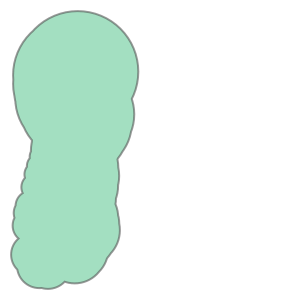

In [3]:
def get_isochrone(s):
    return s.geometry.buffer(s.walk_distance).unary_union

get_isochrone(stops)

What's nice about this is that iterating different time budgets is very easy:

<AxesSubplot:>

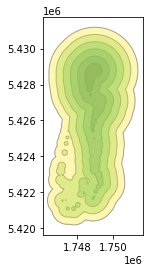

In [4]:
# make an empty list for the isochrones
isochrones = []
times = [t for t in range(10, 70, 10)]
for t in times:
    stops.walk_time = stops.travel_time.apply(get_walk_time, budget = t)
    stops.walk_distance = stops.walk_time.apply(get_walk_distance, speed = 40)
    isochrones.append(get_isochrone(stops))
    
isochrones_gdf = geopandas.GeoDataFrame(data = {'times': times}, geometry = geopandas.GeoSeries(isochrones))
isochrones_gdf.crs = stops.crs
isochrones_gdf.plot(column = "times", cmap = "viridis", edgecolor = 'k', alpha = 0.35)

## Building plugins in QGIS
Full disclosure (and spoilers) I am not going to explain how to make plugins in QGIS. It's really beyond the scope of this course, and also runs into a few tricky issues with differences across operating systems, which make it kind of painful to introduce. But for the sake of completeness, here are some thoughts on this pathway for GIS customization.

### What is a plugin anyway?
First, we'll look at some examples, becore considering what a plugin really *is*.
+ [QuickMapServices](https://nextgis.com/blog/quickmapservices/) for convenient web basemaps
+ [qgis2web](https://github.com/tomchadwin/qgis2web) for making simple web maps
+ ... and so on

A plugin adds functionality to its 'host' application, in a more or less seamless way, usually well integrated into the main application interface. You can find more about them [here](https://plugins.qgis.org/). Using plugins an organisation can customise the general functionality to better fit their specific needs.

Plugin developers have to program to a specification such that their code meets the expectations of the parent application and can just slot in like any other part of the base application. Behind that 'interface' plugin developers are free to deploy any other modules their plugin functionality requires. For example, it would be possible to deploy machine-learning tools from [sklearn](https://sklearn.org/) to analyse spatial data.

However, it is tricky enough to develop plugins that it is important to consider whether or not they are the most appropriate mode of delivery for the functionality. For example it might be that standalone scripts, jupyter notebooks, or even standalone programs are a better fit. Often the biggest advantage of a plugin is that it reduces the demands on potential end users in terms of installing the various dependencies of the plugin. (This is offset by the challenges of integrating needed libraries into *QGIS* such that they don't interfere with the base python modules used by *QGIS*.)

When significant user interaction is necessary (e.g. georectification) a plugin may be very clearly the best option.

### Where can I get them?
Already answered this question! Use **Plugins - Manage and Install Plugins...**.

### How do I build one?
That's where it gets messy. Online resources are your best friend here, along with a couple of books. Building applications with user interface elements is tricky and complicated. I might have more to say about this in years to come, but for now plugin development remains a bit of a mystery for me!

## More resources
+ I started into this with the excellent materials at [this University of Helsinki class](https://automating-gis-processes.github.io/site/lessons/L7/pyqgis.html)
+ The [PyQGIS Developer cookbook](https://docs.qgis.org/3.16/en/docs/pyqgis_developer_cookbook/index.html)
+ The [`pqgis` API documentation](https://qgis.org/pyqgis/master/) is essential
+ There are [good books also](https://ebookcentral-proquest-com.helicon.vuw.ac.nz/lib/vuw/detail.action?docID=1912003&pq-origsite=primo), although be sure to check that they are up to date as the tools change regularly

### And finally...
Put that Jupyter notebook learning to use! You can install the `pyqgis` modules into an environment and work with them directly outside of the application itself. And ESRI are also into notebooks, see [here](https://www.esri.com/en-us/arcgis/products/arcgis-notebooks/overview) for more! 